.ipynb settings

In [1]:
#Settings relative to .ipynb file format that have to be executed here

#Make reloading of modules automatic et évite d'avoir à redémarer le kernel et tout re executer pour appliquer la modification d'un module dans __main__.
%load_ext autoreload  
%autoreload 2

In [2]:
#src.useful_functions
import sys
sys.path.append('../src')  # Adjust the path to import modules in src/

import useful_functions

Importation of the dataset(s)

In [3]:
#Importing dataset(s)
from data import make_dataset

#Load the train and test datasets:
X_train_00   = make_dataset.load_data(False, 'processed/split/X_train_00')
Y_train_00   = make_dataset.load_data(False, 'processed/split/Y_train_00')
X_test_00 = make_dataset.load_data(False, 'processed/split/X_test_00')
Y_test_00 = make_dataset.load_data(False, 'processed/split/Y_test_00')


#Load the not_split train and test datasets:
X   = make_dataset.load_data(False, 'processed/not_split/X')
Y   = make_dataset.load_data(False, 'processed/not_split/Y')
X_info = make_dataset.load_data(False, 'processed/not_split/X_info')


# VI) <u> Pipeline development 

<span style="color:#FF1493;"> <strong> <font size="4">1) Logistic Regression Pipeline and GridSearchCV implementation

In [7]:

# --------------------------------------------------------------
# Correlated features remover (not used)
# --------------------------------------------------------------

from features import features_selection
from configuration import constant_variables
from dvclive import Live


#Correlated features remover definition (it's a transformer)
corr_features_selector = features_selection.correlated_features_removal_transformer(corr_threshold = 0.95)


# --------------------------------------------------------------
# Features selector
# --------------------------------------------------------------

"""
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model_sfs = LogisticRegression(max_iter=10000, C = 0.3, random_state =33, penalty = 'l2')
sequ_feat_selector = SFS(estimator = model_sfs, k_features = 'best', forward = True, verbose = 0, cv=constant_variables.CV, scoring = 'neg_log_loss', n_jobs = -1)
"""

#OU

#Filter features selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
filter_feat_selector = SelectKBest(f_classif, k= 10)

# --------------------------------------------------------------
# Scaler
# --------------------------------------------------------------

from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = StandardScaler()


# --------------------------------------------------------------
# Model
# --------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'l1', fit_intercept=True, random_state = 999, solver = 'saga', max_iter= 3000, verbose = False, tol=1e-4)

# --------------------------------------------------------------
# Pipeline
# --------------------------------------------------------------
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[("scaler",scaler), ("features_selector",filter_feat_selector), ("model", model)])


#parameters to optimize definition
import numpy as np
parameters = {'model__penalty': ['l1', 'l2', 'elasticnet', 'None'],
             'model__C': np.logspace(-3, 1, 21),
             'model__solver': ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs'],
             'features_selector__k' : [12,13,14]
             }

# --------------------------------------------------------------
# GridSearchCV
# --------------------------------------------------------------
# Create a GridSearchCV object
from sklearn.model_selection import GridSearchCV
from configuration import constant_variables

grid_search = GridSearchCV(pipeline, parameters, cv=constant_variables.CV, scoring = 'neg_log_loss', verbose=0)
# Fit the GridSearchCV to the data
grid_search.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())




c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
4095 fits failed out of a total of 6300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
315 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('features_selector', SelectKBest()),
                                       ('model',
                                        LogisticRegression(max_iter=3000,
                                                           penalty='l1',
                                                           random_state=999,
                                                           solver='saga',
                                                           verbose=False))]),
             param_grid={'features_selector__k': [12, 13, 14],
                         'model__C': array([1.00000000e-03, 1.58...
       6.30957344e-03, 1.00000000e-02, 1.58489319e-02, 2.51188643e-02,
       3.98107171e-02, 6.30957344e-02, 1.00000000e-01, 1.58489319e-01,
       2.51188643e-01, 3.98107171e-01, 6.30957344e-01, 1.00000000e+00,
       1.58489319e+00, 2.51188643e+00, 3.98107171e+00, 6.30957344e+00,
       1.00000000e+01]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'model__solver': ['saga', 'sag', 'liblinear',
                                           'newton-cg', 'lbfgs']},
             scoring='neg_log_loss')

<span style="color:#FF1493;"> <strong> <font size="4">2) Neural Network Pipeline and GridSearchCV optimisation

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_score, recall_score
import warnings

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2

warnings.filterwarnings("ignore", category=UserWarning)

# --------------------------------------------------------------------
# 1) Fonction de création du NN, avec argument input_dim
# --------------------------------------------------------------------
def create_nn_model_NN(
    input_dim=None,          # <-- scikeras passera input_dim ici
    optimizer='adam',
    activation='relu',
    neurons=32,
    layers=2,
    regularizer=None,
    dropout_rate=0.0,
):
    """
    input_dim : nombre de features. Peut être None => Keras infère si possible,
    mais scikeras essaie souvent de passer un input_dim != None.
    """
    model = Sequential()

    # Première couche
    if input_dim is not None:
        # scikeras a passé un input_dim => on l'utilise explicitement
        model.add(Dense(neurons, activation=activation,
                        kernel_regularizer=regularizer,
                        input_dim=input_dim))
    else:
        # pas d'input_dim => Keras l'infèrera si possible
        model.add(Dense(neurons, activation=activation,
                        kernel_regularizer=regularizer))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # couches cachées suivantes
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation=activation,
                        kernel_regularizer=regularizer))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # couche de sortie
    model.add(Dense(1, activation='sigmoid'))

    # compilation
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model


# --------------------------------------------------------------------
# 2) KerasClassifier scikeras
# --------------------------------------------------------------------
nn_wrapper = KerasClassifier(
    model=create_nn_model_NN,    # wrapper de la fonction
    # hyperparamètres par défaut
    optimizer="adam",
    activation="relu",
    neurons=32,
    layers=2,
    regularizer=None,
    dropout_rate=0.0,
    verbose=0,
    warm_start=False  # reconstruit le modèle à chaque fit
)

# --------------------------------------------------------------------
# 3) Pipeline
# --------------------------------------------------------------------
pipeline_NN = Pipeline([
    ("scaler", StandardScaler()),
    ("features_selector", SelectKBest(f_classif)),
    ("model", nn_wrapper)
])

# --------------------------------------------------------------------
# 4) Grille de paramètres
#    Noter qu'on NE met PAS input_dim dans la grille
# --------------------------------------------------------------------
parameters_NN = {
    'features_selector__k': [6, 11, 13, 16],
    'model__model__optimizer': ['adam', 'rmsprop'],
    'model__model__activation': ['relu', 'tanh'],
    'model__model__neurons': [16, 64],
    'model__model__layers': [2, 3],
    'model__model__regularizer': [None, l1(0.01), l2(0.01)],
    'model__model__dropout_rate': [0.0, 0.3]
}

grid_search_NN = GridSearchCV(
    pipeline_NN,
    parameters_NN,
    cv=3,
    scoring='neg_log_loss',
    verbose=1
)

# --------------------------------------------------------------------
# 5) Entraînement
# --------------------------------------------------------------------
grid_search_NN.fit(X_train_00, Y_train_00)

# --------------------------------------------------------------------
# 6) Résultats
# --------------------------------------------------------------------
print("Best Parameters:", grid_search_NN.best_params_)
print("Best Score:", grid_search_NN.best_score_)



c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The KerasClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 3 folds for each of 384 candidates, totalling 1152 fits


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The KerasClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The KerasClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin

ValueError: 
All the 1152 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6912' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6913' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6914' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6915' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6916' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6917' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6918' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6919' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6920' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6921' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6922' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6923' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6924' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6925' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6926' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6927' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6928' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6929' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6930' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6931' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6932' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6933' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6934' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6935' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6936' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6937' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6938' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6939' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6940' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6941' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6942' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6943' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6944' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6945' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6946' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6947' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6948' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6949' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6950' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6951' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6952' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6953' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6954' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6955' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6956' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6957' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6958' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6959' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6960' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6961' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6962' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6963' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6964' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6965' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6966' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6967' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6968' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6969' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6970' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6971' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6972' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6973' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6974' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6975' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6976' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6977' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6978' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6979' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6980' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6981' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6982' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6983' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6984' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6985' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6986' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6987' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6988' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6989' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6990' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6991' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6992' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6993' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6994' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6995' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6996' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6997' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6998' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6999' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7000' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7001' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7002' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7003' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7004' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7005' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7006' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7007' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7008' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7009' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7010' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7011' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7012' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7013' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7014' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7015' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7016' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7017' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7018' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7019' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7020' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7021' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7022' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7023' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7024' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7025' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7026' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7027' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7028' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7029' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7030' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7031' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7032' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7033' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7034' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7035' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7036' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7037' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7038' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7039' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7040' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7041' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7042' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7043' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7044' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7045' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7046' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7047' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7048' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7049' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7050' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7051' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7052' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7053' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7054' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7055' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7056' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7057' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7058' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7059' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7060' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7061' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7062' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7063' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7064' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7065' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7066' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7067' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7068' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7069' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7070' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7071' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7072' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7073' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7074' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7075' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7076' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7077' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7078' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7079' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7080' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7081' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7082' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7083' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7084' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7085' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7086' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7087' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7088' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7089' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7090' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7091' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7092' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7093' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7094' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7095' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7096' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7097' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7098' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7099' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7100' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7101' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7102' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7103' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7104' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7105' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7106' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7107' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7108' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7109' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7110' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7111' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7112' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7113' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7114' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7115' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7116' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7117' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7118' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7119' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7120' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7121' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7122' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7123' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7124' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7125' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7126' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7127' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7128' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7129' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7130' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7131' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7132' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7133' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7134' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7135' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7136' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7137' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7138' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7139' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7140' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7141' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7142' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7143' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7144' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7145' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7146' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7147' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7148' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7149' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7150' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7151' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7152' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7153' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7154' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7155' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7156' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7157' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7158' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7159' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7160' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7161' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7162' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7163' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7164' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7165' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7166' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7167' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7168' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7169' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7170' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7171' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7172' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7173' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7174' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7175' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7176' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7177' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7178' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7179' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7180' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7181' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7182' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7183' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7184' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7185' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7186' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7187' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7188' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7189' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7190' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7191' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7192' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7193' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7194' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7195' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7196' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7197' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7198' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7199' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7200' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7201' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7202' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7203' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7204' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7205' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7206' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7207' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7208' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7209' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7210' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7211' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7212' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7213' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7214' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7215' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7216' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7217' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7218' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7219' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7220' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7221' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7222' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7223' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7224' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7225' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7226' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7227' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7228' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7229' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7230' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7231' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7232' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7233' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7234' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7235' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7236' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7237' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7238' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7239' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7240' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7241' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7242' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7243' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7244' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7245' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7246' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7247' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7248' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7249' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7250' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7251' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7252' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7253' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7254' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7255' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7256' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7257' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7258' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7259' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7260' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7261' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7262' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7263' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7264' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7265' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7266' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7267' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7268' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7269' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7270' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7271' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7272' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7273' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7274' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7275' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7276' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7277' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7278' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7279' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7280' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7281' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7282' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7283' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7284' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7285' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7286' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7287' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7288' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7289' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7290' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7291' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7292' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7293' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7294' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7295' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7296' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7297' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7298' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7299' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7300' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7301' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7302' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7303' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7304' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7305' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7306' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7307' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7308' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7309' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7310' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7311' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7312' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7313' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7314' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7315' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7316' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7317' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7318' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7319' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7320' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7321' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7322' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7323' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7324' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7325' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7326' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7327' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7328' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7329' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7330' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7331' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7332' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7333' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7334' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7335' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7336' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7337' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7338' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7339' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7340' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7341' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7342' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7343' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7344' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7345' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7346' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7347' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7348' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7349' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7350' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7351' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7352' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7353' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7354' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7355' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7356' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7357' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7358' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7359' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7360' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7361' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7362' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7363' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7364' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7365' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7366' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7367' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7368' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7369' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7370' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7371' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7372' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7373' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7374' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7375' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7376' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7377' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7378' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7379' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7380' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7381' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7382' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7383' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7384' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7385' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7386' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7387' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7388' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7389' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7390' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7391' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7392' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7393' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7394' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7395' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7396' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7397' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7398' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7399' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7400' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7401' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7402' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7403' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7404' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7405' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7406' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7407' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7408' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7409' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7410' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7411' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7412' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7413' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7414' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7415' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7416' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7417' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7418' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7419' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7420' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7421' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7422' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7423' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7424' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7425' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7426' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7427' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7428' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7429' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7430' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7431' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7432' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7433' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7434' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7435' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7436' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7437' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7438' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7439' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7440' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7441' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7442' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7443' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7444' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7445' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7446' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7447' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7448' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7449' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7450' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7451' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7452' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7453' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7454' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7455' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7456' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7457' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7458' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7459' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7460' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7461' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7462' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7463' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7464' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7465' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7466' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7467' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7468' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7469' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7470' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7471' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7472' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7473' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7474' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7475' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7476' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7477' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7478' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7479' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7480' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7481' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7482' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7483' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7484' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7485' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7486' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7487' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7488' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7489' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7490' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7491' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7492' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7493' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7494' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7495' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7496' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7497' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7498' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7499' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7500' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7501' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7502' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7503' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7504' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7505' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7506' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7507' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7508' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7509' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7510' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7511' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7512' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7513' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7514' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7515' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7516' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7517' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7518' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7519' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7520' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7521' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7522' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7523' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7524' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7525' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7526' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7527' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7528' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7529' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7530' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7531' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7532' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7533' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7534' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7535' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7536' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7537' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7538' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7539' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7540' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7541' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7542' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7543' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7544' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7545' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7546' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7547' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7548' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7549' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7550' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7551' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7552' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7553' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7554' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7555' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7556' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7557' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7558' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7559' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7560' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7561' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7562' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7563' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7564' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7565' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7566' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7567' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7568' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7569' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7570' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7571' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7572' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7573' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7574' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7575' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7576' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7577' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7578' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7579' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7580' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7581' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7582' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7583' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7584' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7585' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7586' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7587' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7588' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7589' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7590' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7591' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7592' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7593' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7594' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7595' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7596' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7597' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7598' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7599' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7600' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7601' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7602' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7603' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7604' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7605' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7606' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7607' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7608' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7609' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7610' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7611' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7612' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7613' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7614' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7615' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7616' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7617' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7618' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7619' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7620' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7621' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7622' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7623' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7624' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7625' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7626' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7627' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7628' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7629' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7630' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7631' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7632' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7633' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7634' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7635' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7636' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7637' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7638' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7639' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7640' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7641' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7642' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7643' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7644' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7645' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7646' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7647' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7648' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7649' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7650' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7651' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7652' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7653' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7654' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7655' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7656' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7657' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7658' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7659' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7660' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7661' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7662' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7663' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7664' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7665' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7666' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7667' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7668' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7669' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7670' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7671' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7672' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7673' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7674' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7675' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7676' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7677' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7678' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7679' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7680' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7681' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7682' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7683' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7684' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7685' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7686' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7687' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7688' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7689' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7690' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7691' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7692' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7693' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7694' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7695' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7696' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7697' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7698' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7699' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7700' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7701' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7702' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7703' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7704' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7705' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7706' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7707' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7708' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7709' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7710' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7711' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7712' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7713' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7714' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7715' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7716' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7717' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7718' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7719' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7720' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7721' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7722' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7723' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7724' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7725' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7726' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7727' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7728' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7729' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7730' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7731' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7732' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7733' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7734' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7735' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7736' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7737' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7738' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7739' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7740' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7741' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7742' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7743' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7744' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7745' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7746' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7747' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7748' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7749' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7750' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7751' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7752' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7753' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7754' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7755' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7756' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7757' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7758' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7759' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7760' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7761' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7762' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7763' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7764' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7765' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7766' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7767' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7768' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7769' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7770' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7771' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7772' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7773' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7774' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7775' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7776' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7777' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7778' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7779' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7780' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7781' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7782' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7783' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7784' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7785' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7786' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7787' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7788' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7789' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7790' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7791' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7792' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7793' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7794' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7795' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7796' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7797' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7798' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7799' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7800' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7801' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7802' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7803' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7804' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7805' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7806' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7807' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7808' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7809' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7810' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7811' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7812' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7813' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7814' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7815' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7816' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7817' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7818' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7819' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7820' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7821' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7822' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7823' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7824' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7825' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7826' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7827' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7828' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7829' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7830' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7831' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7832' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7833' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7834' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7835' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7836' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7837' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7838' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7839' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7840' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7841' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7842' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7843' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7844' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7845' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7846' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7847' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7848' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7849' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7850' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7851' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7852' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7853' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7854' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7855' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7856' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7857' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7858' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7859' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7860' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7861' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7862' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7863' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7864' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7865' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7866' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7867' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7868' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7869' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7870' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7871' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7872' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7873' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7874' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7875' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7876' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7877' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7878' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7879' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7880' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7881' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7882' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7883' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7884' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7885' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7886' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7887' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7888' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7889' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7890' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7891' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7892' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7893' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7894' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7895' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7896' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7897' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7898' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7899' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7900' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7901' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7902' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7903' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7904' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7905' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7906' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7907' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7908' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7909' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7910' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7911' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7912' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7913' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7914' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7915' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7916' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7917' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7918' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7919' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7920' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7921' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7922' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7923' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7924' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7925' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7926' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7927' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7928' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7929' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7930' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7931' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7932' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7933' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7934' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7935' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7936' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7937' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7938' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7939' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7940' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7941' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7942' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7943' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7944' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7945' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7946' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7947' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7948' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7949' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7950' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7951' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7952' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7953' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7954' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7955' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7956' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7957' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7958' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7959' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7960' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7961' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7962' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7963' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7964' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7965' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7966' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7967' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7968' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7969' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7970' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7971' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7972' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7973' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7974' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7975' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7976' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7977' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7978' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7979' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7980' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7981' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7982' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7983' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7984' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7985' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7986' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7987' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7988' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7989' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7990' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7991' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7992' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7993' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7994' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7995' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7996' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7997' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7998' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7999' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8000' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8001' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8002' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8003' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8004' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8005' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8006' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8007' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8008' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8009' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8010' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8011' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8012' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8013' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8014' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8015' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8016' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8017' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8018' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8019' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8020' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8021' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8022' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8023' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8024' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8025' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8026' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8027' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8028' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8029' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8030' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8031' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8032' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8033' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8034' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8035' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8036' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8037' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8038' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8039' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8040' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8041' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8042' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8043' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8044' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8045' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8046' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8047' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8048' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8049' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8050' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8051' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8052' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8053' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8054' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8055' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8056' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8057' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8058' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8059' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8060' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8061' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8062' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8063' has no defined outputs yet.


<span style="color:#808080;"> <strong> <font size="4">3) Model calibration (Not used for Logistic Reg)

In [104]:

#definition of a calibrator
"""
from sklearn.calibration import CalibratedClassifierCV
calibrated_pipeline = CalibratedClassifierCV(chosen_pipeline_trained, cv = 'prefit' , method = 'isotonic', ensemble = True)
calibrated_pipeline.fit(X_valid_00.copy(), Y_valid_00.copy())
"""


"\nfrom sklearn.calibration import CalibratedClassifierCV\ncalibrated_pipeline = CalibratedClassifierCV(chosen_pipeline_trained, cv = 'prefit' , method = 'isotonic', ensemble = True)\ncalibrated_pipeline.fit(X_valid_00.copy(), Y_valid_00.copy())\n"

<span style="color:#FF1493;"> <strong> <font size="4">4) Display GridSearchCV results

Pipeline(steps=[('scaler', StandardScaler()),
                ('features_selector', SelectKBest(k=14)),
                ('model',
                 LogisticRegression(C=0.025118864315095808, max_iter=3000,
                                    random_state=999, verbose=False))])
Best Parameters: {'features_selector__k': 14, 'model__C': 0.025118864315095808, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

Best score with these hyperparameters: -0.5874742408128425

Selected Features: ['Diff_Avg_points_pm_ponderated_by_adversary_perf', 'Diff_Avg_goal_diff', 'Diff_Avg_scored_g_conceeded_g_ratio', 'Diff_Avg_collected_points', 'Diff_Annual_budget', 'Diff_Points_5lm', 'Diff_Goal_Diff_5lm', 'Diff_avg_corners_nb', 'Diff_Avg_shots_nb', 'Diff_Avg_shots_on_target_nb', 'Diff_Avg_fouls_nb', 'Diff_Avg_possession', 'Diff_Avg_xg', 'H_A_status']


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\notebooks\../src\pipeline\results.py:496: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_info_pred = pd.concat([X_info_pred, X_test_info_for_this_seas], ignore_index=True, axis=0)


Successfully loaded the datasets: best_pipeline_results


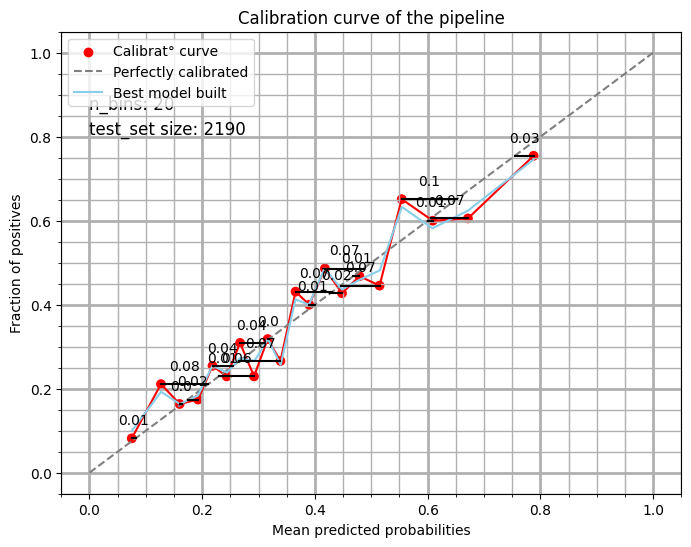

Above learning curve statistics on bins:

╒════╤════════════════╤═════════════════════════════╕
│    │ Bin interval   │   Predictions nb in the bin │
╞════╪════════════════╪═════════════════════════════╡
│  0 │ [0.02, 0.11]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  1 │ [0.11, 0.14]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  2 │ [0.14, 0.18]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  3 │ [0.18, 0.21]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  4 │ [0.21, 0.23]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  5 │ [0.23, 0.25]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  6 │ [0.25, 0.28]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  7 │ [0.28, 0.3]    │                 

In [8]:
#src.pipeline.results

from sklearn.base import clone

from pipeline import results

# On récupère la pipeline avec ses parametres optimaux 
chosen_pipeline = grid_search.best_estimator_

# We print the results of GridSearchCV() execution
print(chosen_pipeline)
results.GridSearchCV_results(grid_search, X_train_00.copy())


# Plot Calibration curve for the pipeline build by GridSearchCV
test_seasons = [2021,2022,2023,2024]

# Make proba predictions retraining the pipeline at every Game Week or every Season on test_seasons:
proba_predicted_GW_training, Y_test_GW_training, X_info_test_GW_training = results.proba_prediction_retrained_each_seas(X, Y, X_info, clone(chosen_pipeline), 'season', test_seasons)

#Plot Calibration curve of the pipeline and info about its bins
prob_pred_01, prob_true_01 = results.plot_calibration_curve_2(
                                Y_test_0 = Y_test_GW_training.copy(),
                                X_train_0 = X_info_test_GW_training.copy(),
                                proba_pred_0 = proba_predicted_GW_training.copy(),
                                n_bins_0 = 20,
                                strategy_0 = 'quantile',
                                color_0 = 'red',
                                GW_training_or_not = True,
                                )

#We display statistics on the pipeline probabilities deviation 
results.print_calibration_stats(prob_pred_01.copy(),
                                prob_true_01.copy(),
                                'non calibrated')


<span style="color:#FF1493;"> <strong> <font size="4">5) Pipeline and dataframes Saving


In [9]:
#src.pipeline.model

# If we consider that the pipeline obtained through GridSearchCV is promising and warrants further evaluation, we save it with the status 'under testing'.
# It will then be loaded in the `pipeline_test.ipynb` notebook for additional testing. Based on the results, we may decide to finalize and save it under the 'chosen' or 'best' status.


from pipeline import model
from features.features_selection import restricted_datasets


#On récupère la pipeline avec ses parametres optimaux 
under_testing_pipeline = grid_search.best_estimator_
under_testing_pipeline_trained = chosen_pipeline.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())

# Save the pipeline
model.save_pipeline(under_testing_pipeline_trained, "under_testing_pipeline_trained")
model.save_pipeline(under_testing_pipeline, "under_testing_pipeline")


Successfully deleted the old pipeline:     under_testing_pipeline_trained
Successfully saved the new pipeline:       under_testing_pipeline_trained


Successfully deleted the old pipeline:     under_testing_pipeline
Successfully saved the new pipeline:       under_testing_pipeline


